In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, accuracy, NMF
from surprise.model_selection import train_test_split, cross_validate

### Method 3 (Using scikit-surprise)

In [23]:
reader = Reader(name=None, line_format=u'user item rating', sep=None, rating_scale=(1, 5), skip_lines=0)
    
train_data = Dataset.load_from_file('data/train_cleaned.txt', reader)
test_data = Dataset.load_from_file('data/test_cleaned.txt', reader)

train_data = train_data.build_full_trainset()
test_data = test_data.build_full_trainset().build_testset()

for reg in [10**-4, 10**-3, 0.01, 0.1, 1, 0]:
    print("reg: {}".format(reg))
    algo = SVD(n_factors =150, biased=True, reg_all = reg, n_epochs = 75)
    algo.fit(train_data)
    # User factors (u)
    u = algo.pu
    # Item factors (v)
    v = algo.qi
    predictions = algo.test(test_data)
    print(accuracy.mse(predictions))
print("\n")

for lr in [0.3, 0.03, 0.003,0.0003]:
    print("lr: {}".format(lr))
    algo = SVD(n_factors = 150, biased=True, reg_all = 0.1, lr_all = lr, n_epochs = 75)
    algo.fit(train_data)
    # User factors (u)
    u = algo.pu
    # Item factors (v)
    v = algo.qi
    predictions = algo.test(test_data)
    print(accuracy.mse(predictions))

reg: 0.0001
MSE: 1.0919
1.0918896693567046
reg: 0.001
MSE: 1.0980
1.09796977603175
reg: 0.01
MSE: 0.9645
0.9645254116728543
reg: 0.1
MSE: 0.8155
0.8154609685498779
reg: 1
MSE: 0.9631
0.9630872581850239
reg: 0
MSE: 1.1076
1.107619689997704


lr: 0.3
MSE: 3.4138
3.4138
lr: 0.03
MSE: 0.8244
0.8244310782485962
lr: 0.003
MSE: 0.8246
0.8246430462973471
lr: 0.0003
MSE: 0.9121
0.9121468284149316


In [29]:
train_data = Dataset.load_from_file('data/train_cleaned.txt', reader)
test_data = Dataset.load_from_file('data/test_cleaned.txt', reader)

train_data = train_data.build_full_trainset()
test_data = test_data.build_full_trainset().build_testset()

# Best setup on train dataset
algo = SVD(n_factors = 150, biased=True, reg_all = 0.1, lr_all = 0.03, n_epochs = 75)
algo.fit(train_data)
# User factors (u)
U = algo.pu
# Item factors (v)
V = algo.qi
predictions = algo.test(test_data)
print(accuracy.mse(predictions))

MSE: 0.8239
0.8238756800189245


In [30]:
np.random.seed(42)

# Best setup on entire dataset
reader = Reader(name=None, line_format=u'user item rating', sep=None, rating_scale=(1, 5), skip_lines=0)
  
algo = SVD(n_factors = 150, biased=True, reg_all = 0.1, lr_all = 0.03, n_epochs = 75)
all_data = Dataset.load_from_file('data/data_cleaned.txt', reader).build_full_trainset()

algo.fit(all_data)

# User factors (u)
U = algo.pu
# Item factors (v)
V = algo.qi

## Visualize and Interpret Results

In [32]:
# Visualize and interpret results
def visualize(U, V):
    ''' 
        U (k x M)
        V (k x N)
    '''
    A, sigma, B = np.linalg.svd(V)
    U_tilde = np.matmul(np.transpose(A[:,:2]), U)
    V_tilde = np.matmul(np.transpose(A[:,:2]), V)
    return U_tilde, V_tilde
    
U_tilde, V_tilde = visualize(np.transpose(U), np.transpose(V))

print(U_tilde.shape)
print(V_tilde.shape)

(2, 943)
(2, 1664)


In [33]:
colnames = ['movie_id', 'title', 'unknown', "action", "adventure", "animation", 
            "childrens", "comedy", "crime", "documentary", "drama", "fantasy", 
            "film-noir", "horror", "musical", "mystery", "romance", "sci-fi", 
            "thriller", "war", "western"]
movie_info = pd.read_csv("data/movies.txt", names=colnames, sep='\t', header=None)

movie_to_genre = dict()

for index, row in movie_info.iterrows():
    if row['title'] not in movie_to_genre:
        movie_to_genre[row['title']] = row['unknown':'western'].to_numpy()

id_to_movie_title = movie_info['title'].tolist()
id_to_movie_title.insert(0, "NO MOVIE WITH ID 0")

movie_to_id = dict()

for i in range(1,len(id_to_movie_title)):
    if (id_to_movie_title[i] not in movie_to_id):
        movie_to_id[id_to_movie_title[i]] = i        
        
ids_cleaned = list(set(np.loadtxt("data/data_cleaned.txt", dtype=int)[:,1]))

### Plot 10 Movies from Entire Dataset

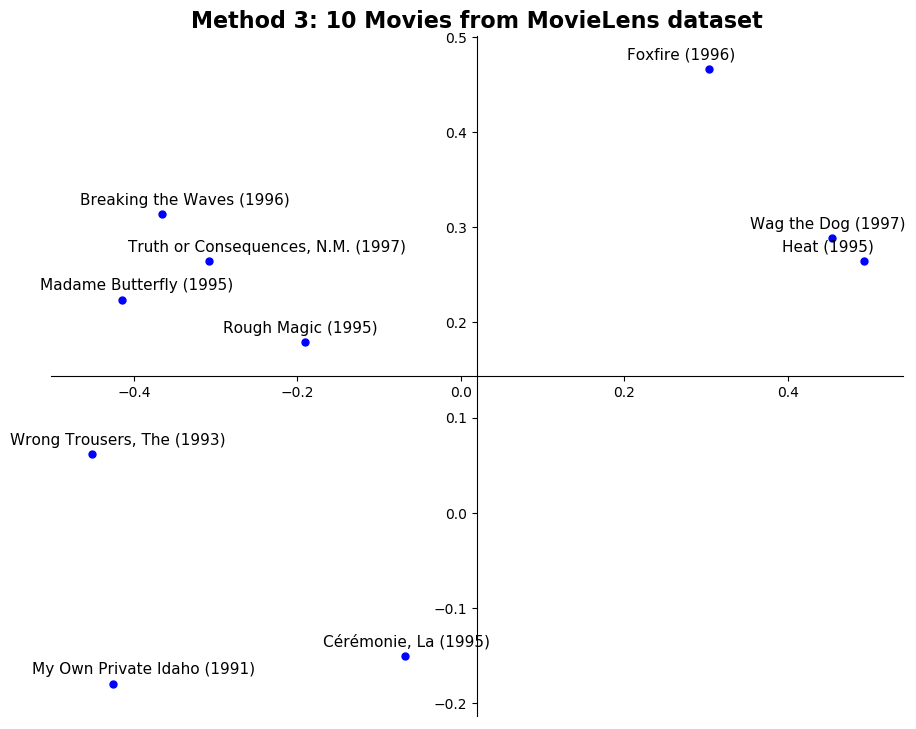

In [34]:
np.random.seed(42)

movie_ids = sorted(np.random.choice(ids_cleaned, 10, replace=False))
movies = [id_to_movie_title[i] for i in movie_ids]

# ====================== TEN CHOSEN MOVIES PLOT ======================
V_ten = np.take(np.transpose(V_tilde), movie_ids, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_ten)):
    x = V_ten[i][0]
    y = V_ten[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.01, movies[i], fontsize=11)
plt.title('Method 3: 10 Movies from MovieLens dataset', fontsize=16, fontweight='bold')
plt.show()

### Plot 10 Most Popular Movies

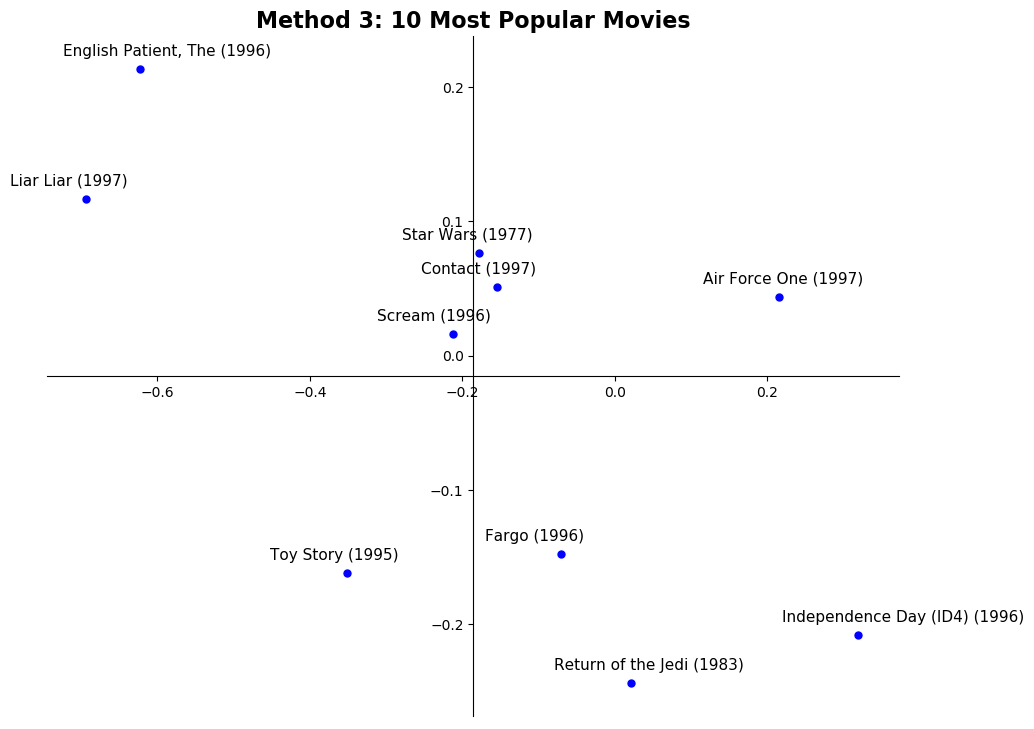

In [35]:
popular_movies = ['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 
                  'Return of the Jedi (1983)', 'Liar Liar (1997)', 
                  'English Patient, The (1996)', 'Scream (1996)', 
                  'Toy Story (1995)', 'Air Force One (1997)', 
                  'Independence Day (ID4) (1996)']
pop_movies_id = [movie_to_id[m] for m in popular_movies]

# ====================== TEN MOST POPULAR MOVIES PLOT ======================
V_pop = np.take(np.transpose(V_tilde), pop_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_pop)):
    x = V_pop[i][0]
    y = V_pop[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.01, popular_movies[i], fontsize=11)
plt.title('Method 3: 10 Most Popular Movies', fontsize=16, fontweight='bold')
plt.show()

### Plot 10 Best Movies

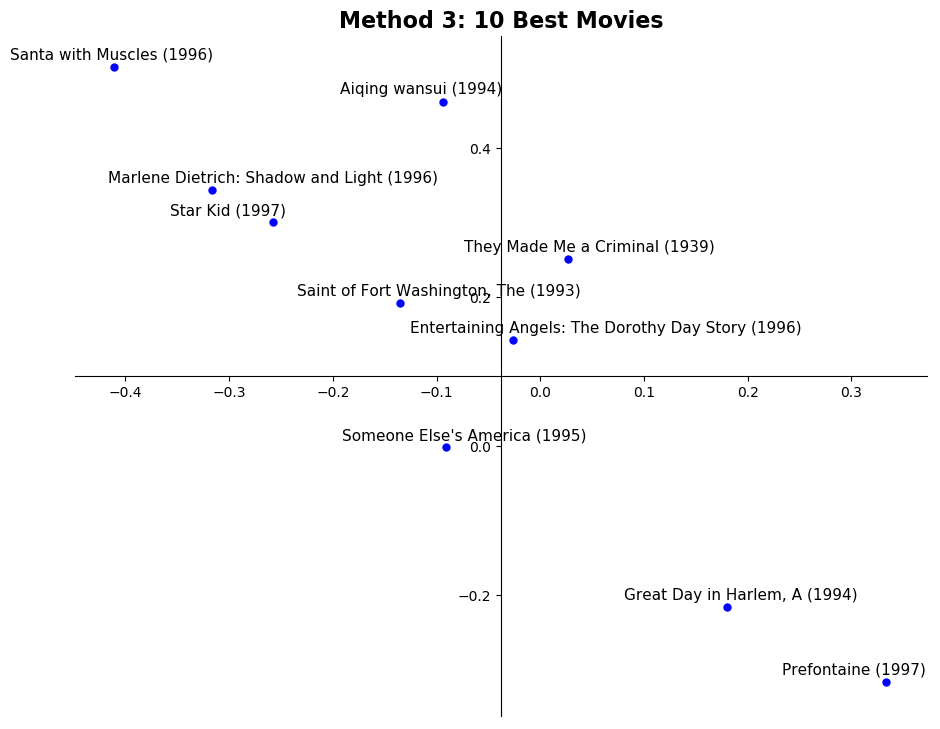

In [36]:
best_movies = ['Prefontaine (1997)', 'Santa with Muscles (1996)', 
               'Great Day in Harlem, A (1994)', 'Aiqing wansui (1994)', 
               'Star Kid (1997)', "Someone Else's America (1995)", 
               'Entertaining Angels: The Dorothy Day Story (1996)', 
               'Saint of Fort Washington, The (1993)', 
               'They Made Me a Criminal (1939)', 
               'Marlene Dietrich: Shadow and Light (1996) ']

best_movies_id = [movie_to_id[m] for m in best_movies]

# ====================== TEN BEST MOVIES PLOT ======================
V_best = np.take(np.transpose(V_tilde), best_movies_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_best)):
    x = V_best[i][0]
    y = V_best[i][1]
    plt.scatter(x, y, marker='.', color='blue', s=100)
    plt.text(x - 0.1, y + 0.01, best_movies[i], fontsize=11)
plt.title('Method 3: 10 Best Movies', fontsize=16, fontweight='bold')
plt.show()

### Plot 10 Movies from 3 Genres

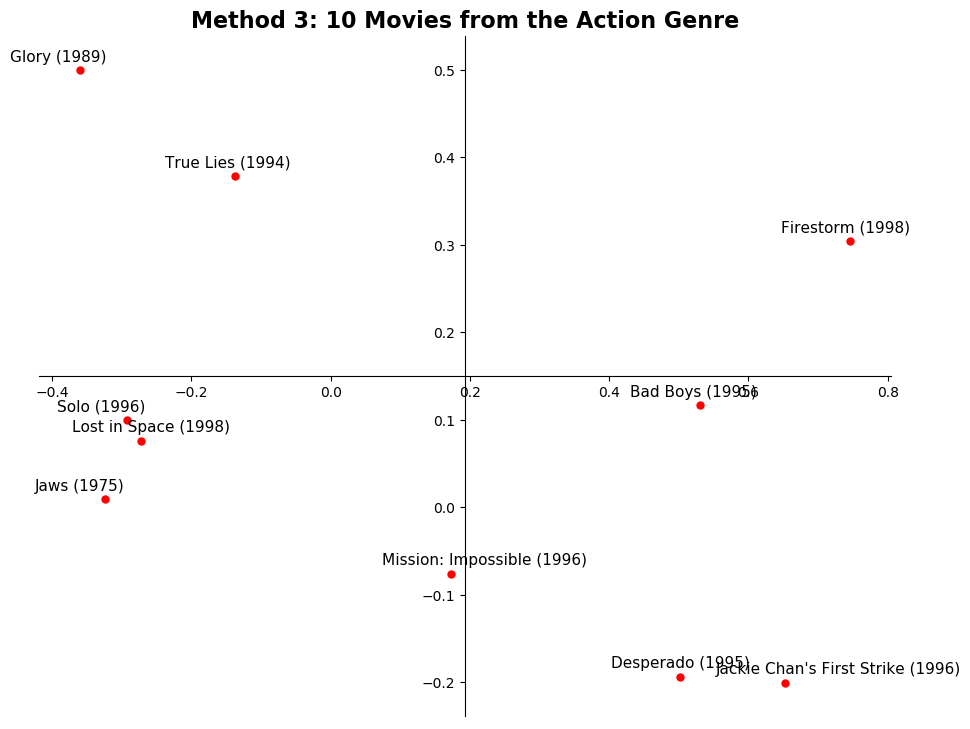

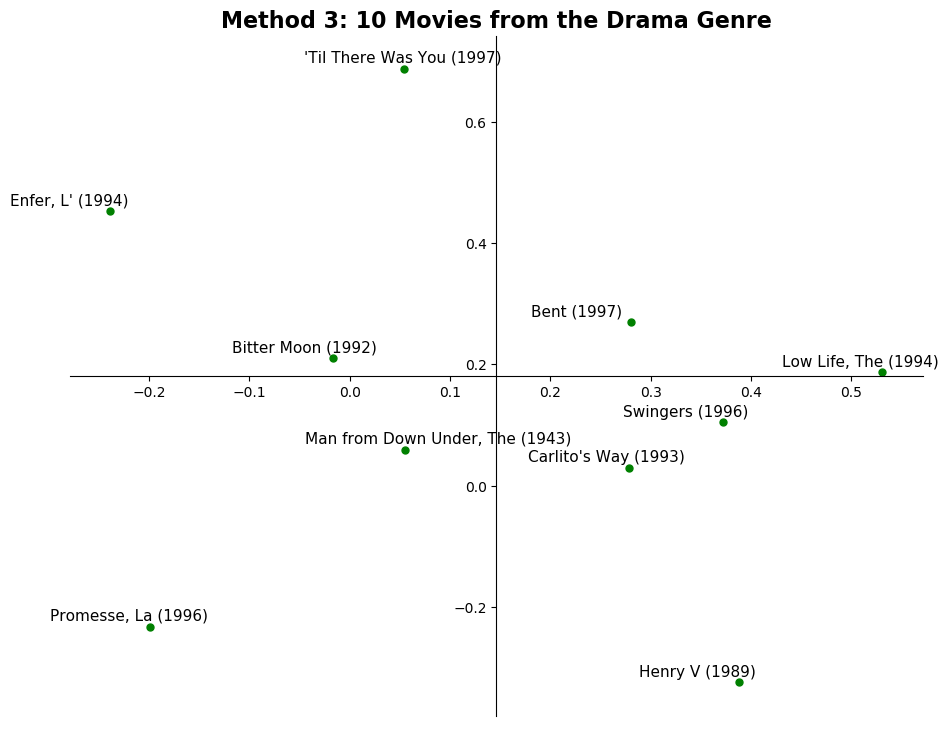

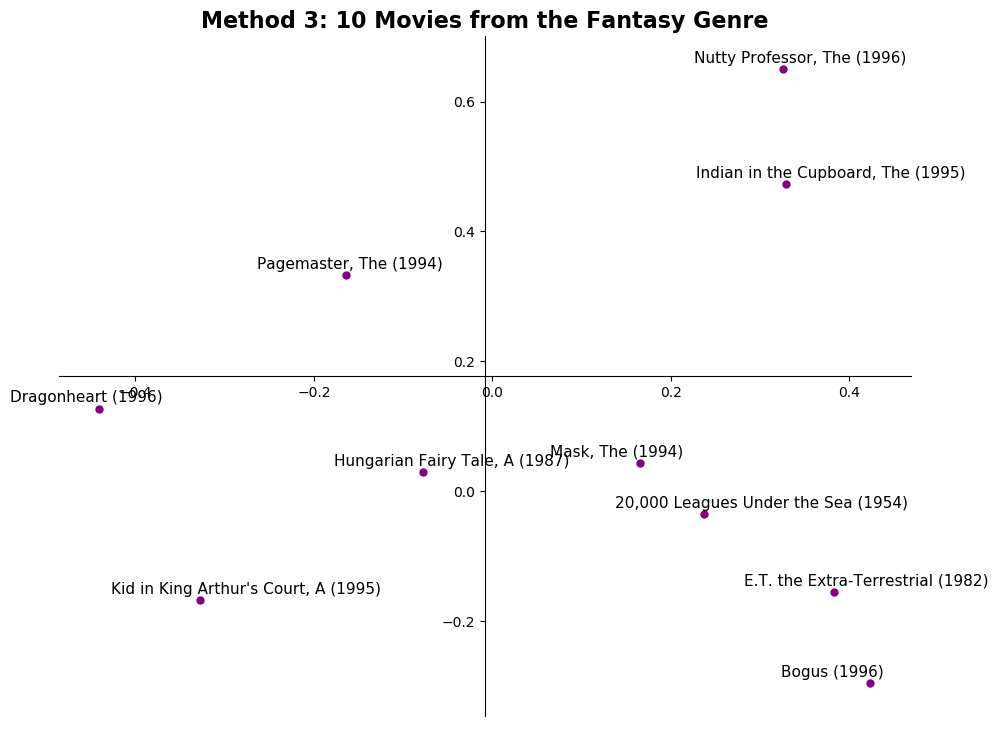

In [37]:
action = []
drama = []
fantasy = []

for key, val in movie_to_genre.items():
    if val[1]:
        action.append(key)
    if val[8]:
        drama.append(key)
    if val[9]:
        fantasy.append(key)
        
np.random.seed(42)

action = np.random.choice(action, 10, replace=False)
action_id = [movie_to_id[m] for m in action]

np.random.seed(42)
drama = np.random.choice(drama, 10, replace=False)
drama_id = [movie_to_id[m] for m in drama]

np.random.seed(42)
fantasy = np.random.choice(fantasy, 10, replace=False)
fantasy_id = [movie_to_id[m] for m in fantasy]

# ====================== TEN MOVIES FROM EACH OF THE THREE GENRES PLOT ======================

# ACTION GENRE
V_action = np.take(np.transpose(V_tilde), action_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_action)):
    x = V_action[i][0]
    y = V_action[i][1]
    plt.scatter(x, y, marker='.', color='red', s=100)
    plt.text(x - 0.1, y + 0.01, action[i], fontsize=11)
plt.title('Method 3: 10 Movies from the Action Genre', fontsize=16, fontweight='bold')
plt.show()

# DRAMA GENRE
V_drama = np.take(np.transpose(V_tilde), drama_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_drama)):
    x = V_drama[i][0]
    y = V_drama[i][1]
    plt.scatter(x, y, marker='.', color='green', s=100)
    plt.text(x - 0.1, y + 0.01, drama[i], fontsize=11)
plt.title('Method 3: 10 Movies from the Drama Genre', fontsize=16, fontweight='bold')
plt.show()

# FANTASY GENRE
V_fantasy = np.take(np.transpose(V_tilde), fantasy_id, axis=0)

fig = plt.figure(figsize=(11, 9), dpi=100)
ax = fig.add_subplot(1, 1, 1)

# Center axes
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in range(len(V_fantasy)):
    x = V_fantasy[i][0]
    y = V_fantasy[i][1]
    plt.scatter(x, y, marker='.', color='purple', s=100)
    plt.text(x - 0.1, y + 0.01, fantasy[i], fontsize=11)
plt.title('Method 3: 10 Movies from the Fantasy Genre', fontsize=16, fontweight='bold')
plt.show()